In [1]:
from dotenv import load_dotenv
from datetime import datetime
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

import warnings
warnings.filterwarnings('ignore')

from scripts.counterfactual import create_synth_control, SynthControlRequest

In [2]:
from dotenv import load_dotenv
import os
from pyoso import Client

load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)
stringify = lambda arr: "'" + "','".join(arr) + "'"

In [3]:
REFRESH = False
if REFRESH:
    df = client.to_pandas("""
        WITH projects AS (
          SELECT
            project_id,
            collection_name
          FROM projects_by_collection_v1
          WHERE collection_name IN (
            'arbitrum-crypto-ecosystems',
            'polygon-crypto-ecosystems',
            'ethereum-crypto-ecosystems',
            'protocol-guild',
            'optimism',
            'op-rpgf3'
          )
        ),
        artifacts AS (
          SELECT
            abp.artifact_id,
            projects.collection_name,
          FROM projects
          JOIN artifacts_by_project_v1 abp
            ON projects.project_id = abp.project_id
          WHERE abp.artifact_source = 'GITHUB'
        ),
        events AS (
          SELECT
            e.bucket_day AS date,
            artifacts.collection_name,
            e.from_artifact_id
          FROM int_events_daily__github AS e
          JOIN artifacts
            ON e.to_artifact_id = artifacts.artifact_id
          WHERE e.event_type = 'COMMIT_CODE'
        ),
        unique_daily AS (
          SELECT DISTINCT
            date,
            collection_name,
            from_artifact_id
          FROM events
        ),
        daily_dev_counts AS (
          SELECT
            date,
            collection_name,
            approx_distinct(from_artifact_id) OVER (
              PARTITION BY collection_name
              ORDER BY date
              RANGE BETWEEN INTERVAL '89' DAY PRECEDING AND CURRENT ROW
            ) AS active_developers_over_90_day
          FROM unique_daily
        )
        SELECT
          date,
          collection_name,
          active_developers_over_90_day
        FROM daily_dev_counts
        ORDER BY
          date,
          collection_name
        """)

    df_timeseries = df.drop_duplicates().copy()
    df_timeseries.columns = ['date', 'origin_key', 'value']
    df_timeseries['metric_key'] = 'active_developers_over_90_day'
    df_timeseries.to_csv('data/_local/timeseries_metrics_updated.csv', index=False)
else:
    df_timeseries = pd.read_csv('data/_local/timeseries_metrics_updated.csv')

df_timeseries['date'] = pd.to_datetime(df_timeseries['date'])    

In [4]:
#df_timeseries['origin_key'].value_counts()
df_timeseries

,date,origin_key,value,metric_key
0,2015-01-01,optimism,1,active_developers_over_90_day
1,2015-01-02,optimism,3,active_developers_over_90_day
2,2015-01-03,optimism,4,active_developers_over_90_day
3,2015-01-04,optimism,4,active_developers_over_90_day
4,2015-01-05,optimism,6,active_developers_over_90_day
...,...,...,...,...
21085,2025-07-10,ethereum-crypto-ecosystems,3110,active_developers_over_90_day
21086,2025-07-10,op-rpgf3,1046,active_developers_over_90_day
21087,2025-07-10,optimism,2687,active_developers_over_90_day
21088,2025-07-10,polygon-crypto-ecosystems,667,active_developers_over_90_day


In [5]:
request = SynthControlRequest(
    time_predictors_prior_start=datetime(2022, 1, 1),
    time_predictors_prior_end=datetime(2024, 1, 1),
    time_optimize_ssr_start=datetime(2023, 10, 1),
    time_optimize_ssr_end=datetime(2025, 4, 1),
    dependent='active_developers_over_90_day',
    treatment_identifier='op-rpgf3',
    controls_identifier=['arbitrum-crypto-ecosystems', 'polygon-crypto-ecosystems', 'ethereum-crypto-ecosystems'],
    predictors=['active_developers_over_90_day']
)

response = create_synth_control(df_timeseries, request)

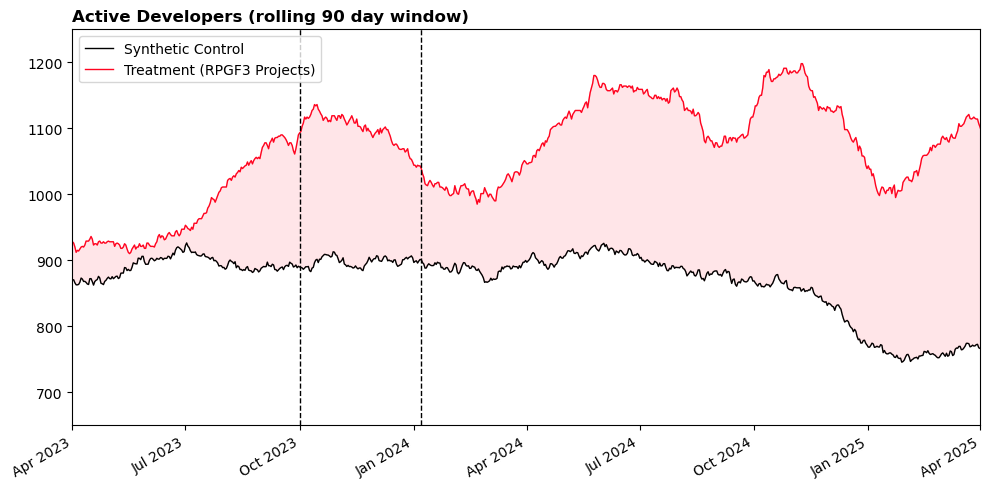

In [6]:
df = pd.DataFrame(response.data).dropna().copy()
df['date'] = pd.to_datetime(df['date'])

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=df, x='date', y='synthetic', label='Synthetic Control', color='black', linewidth=1)
sns.lineplot(data=df, x='date', y='treatment', label='Treatment (RPGF3 Projects)', color='#ff0420', linewidth=1)

ax.set_title('Active Developers (rolling 90 day window)', weight='bold', loc='left')
ax.set_xlabel('')
ax.set_ylabel('')

ax.set_xlim(
    pd.to_datetime("2023-04-01"),
    pd.to_datetime("2025-04-01")
)

ax.legend(frameon=True, loc='upper left')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate(rotation=30, ha='right')

ax.axvline(pd.to_datetime('2023-10-01'), color='black', linestyle='--', linewidth=1)
ax.axvline(pd.to_datetime('2024-01-07'), color='black', linestyle='--', linewidth=1)

ax.fill_between(
    df['date'],
    df['treatment'],
    df['synthetic'],
    where=(df['treatment'] > df['synthetic']),
    interpolate=True,
    color='#ff0420',
    alpha=0.1,
    label='Treatment > Synthetic'
)

ax.fill_between(
    df['date'],
    df['treatment'],
    df['synthetic'],
    where=(df['treatment'] <= df['synthetic']),
    interpolate=True,
    color='black',
    alpha=0.05,
    label='Synthetic ≥ Treatment'
)
ax.set_ylim(650,1250)

plt.tight_layout()
plt.show()

In [7]:
df[df['date'] == pd.to_datetime('2025-01-15')]

,date,treatment,synthetic
3667,2025-01-15,1001.0,759.398878
